In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import pathlib

In [3]:
data_dir = "/content/drive/MyDrive/face_type/face"
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1535


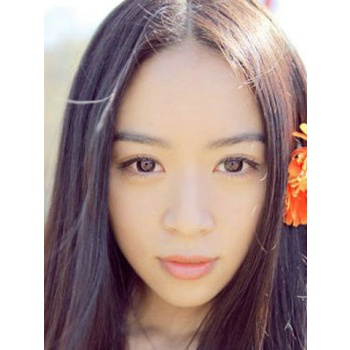

In [5]:
long = list(data_dir.glob('long/*'))
PIL.Image.open(str(long[0]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1535 files belonging to 5 classes.
Using 1228 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1535 files belonging to 5 classes.
Using 307 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['angulate', 'circle', 'egg', 'long', 'triangle']


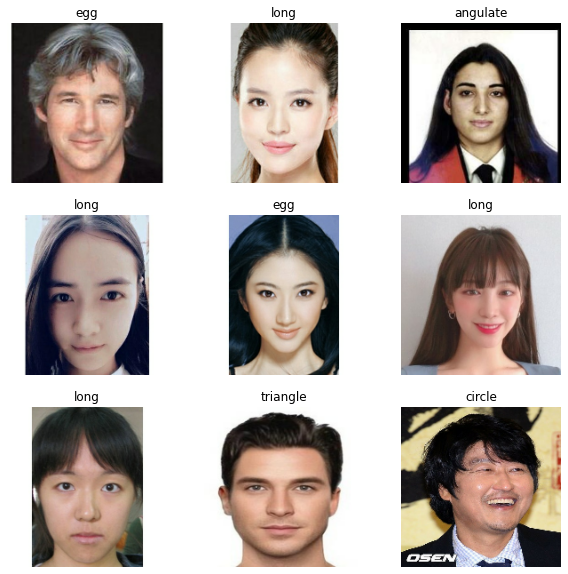

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.11764707 1.0


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization



# ResNet50 불러오기 -> include_top = False로 바꾸는 것이 포인트
base_model = ResNet50(include_top=False, pooling = 'avg' , input_shape = (180,180 ,3), weights = 'imagenet')
base_model.trainable = False

# label(target) 데이터를 수치화 해준다. -> 안해줘도 loss 방법을 (sparse)로하면 되긴한다.
# input_y = tf.keras.utils.to_categorical(train_ds, 5)
# test_y = tf.keras.utils.to_categorical(val_ds, 5)

# 모델 layer 설계
inputs = Input(shape=(180,180,3))
x = tf.keras.layers.experimental.preprocessing.Resizing(180, 180)(inputs)
x = tf.keras.applications.resnet50.preprocess_input(inputs)
x = base_model(x, training = False)
x = Flatten()(x)								# Fully Connected에 온전하게 학습을 위해 펼쳐준다	
outputs = Dense(5, activation = 'softmax')(x)	# Softmax 함수로 10개 분류하는 분류기 
model_res = tf.keras.Model(inputs, outputs)	# model_res 란 이름의 인풋과 아웃풋이 정해진 모델 생성

In [21]:
model_res.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1024

In [22]:
# 모델 컴파일 진행 - 아까와 달리 categorical_crossentropy 사용 > label이 숫자형 데이터이므로
model_res.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

# early stopping 설정
# early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# 모델 fitting
history = model_res.fit(train_ds,validation_data=val_ds, epochs=3)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


39/39 [==============================] - 224s 6s/step - loss: 1.0062 - accuracy: 0.5888 - val_loss: 0.7368 - val_accuracy: 0.6906
Epoch 2/3
39/39 [==============================] - 167s 4s/step - loss: 0.5571 - accuracy: 0.7712 - val_loss: 0.6339 - val_accuracy: 0.7362
Epoch 3/3
39/39 [==============================] - 166s 4s/step - loss: 0.4714 - accuracy: 0.8086 - val_loss: 0.6016 - val_accuracy: 0.7362


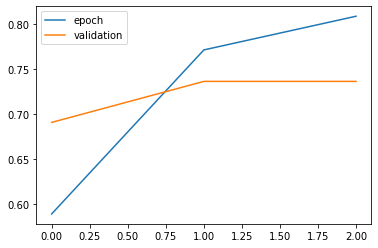

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['epoch', 'validation'], loc = 'upper left')
plt.show()

In [24]:
loss, acc = model_res.evaluate(val_ds,verbose=2)

10/10 - 33s - loss: 0.6016 - accuracy: 0.7362 - 33s/epoch - 3s/step


In [26]:
model_res.save('/content/drive/MyDrive/face_type/transfer_model1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/face_type/transfer_model1/assets
